# GluonTS - Transfer Learning Approach

- Two datasets: A and B
- Dataset $A$: Main dataset of interest (Subset of domain)
 - Ten trials training and evaluating on Dataset $A$
- Dataset $B_i$: Data that is used for comparison. Network is trained on $B_i$ but evaluated on data from $A$
 - This dataset has the same size and is trained exactly the same way. Only difference. A has a higher degree of homogeneity, whereas dataset $B_i$ is a random sample from the same frequency that we are training on. 
 
In this notebook I try to train a network on dataset $B_i$ and evaluate it on $A$ using $i \in {1,2,...,10}$, hence ten different datasets. The results will be compared to ten trials from training and evaluating on dataset A. 


## Imports



In [1]:
import gluonts
import mxnet

print(gluonts.__version__)
print(mxnet.__version__)

0.4.1
1.4.1


In [2]:
# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes
from utils_gluonts10_deepar import deepar


INFO:root:Using CPU


In [3]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_daily_domain', 'm4_hourly', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_domain', 'm4_monthly_finance', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_other', 'm4_monthly_subset10975_seed42', 'm4_monthly_subset10975_seed43', 'm4_monthly_subset10975_seed44', 'm4_monthly_subset10975_seed45', 'm4_monthly_subset10975_seed46', 'm4_monthly_subset10975_seed47', 'm4_monthly_subset10975_seed48', 'm4_monthly_subset10975_seed49', 'm4_monthly_subset10975_seed50', 'm4_monthly_subset10975_seed51', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_domain', 'm4_quarterly_finance', 'm4_quarterly_industry', 'm4_quarterly_macro', 'm4_quarterly_micro', 'm4_quarterly_other', 'm4_weekly', 'm4_weekly_domain', 'm4_weekly_id', 'my_weekly_tm', 'm4_yearly', 'm4_yearly_demographic', 'm4_yearly_domain', 'm4_yearly_finance', 'm4_yearly_industry', 'm4_yearly_

In [4]:
dataname_a = "m4_monthly_micro"
dataset_a = get_dataset(dataname_a, regenerate=False)

INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_micro.


In [5]:
dataname_b = "m4_monthly_subset10975_seed42"
dataset_b = get_dataset(dataname_b, regenerate=False)

INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_subset10975_seed42.


## Check the datasets 

### Dataset A


dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])
length train: 10975
length test: 10975

start:
 1750-01-31 00:00:00
target:
 [3396.89 3257.99 3158.49 3176.81 3157.27 3108.64 3063.8  3098.17 3106.87
 3096.37]
feat_static_cat:
 [1]


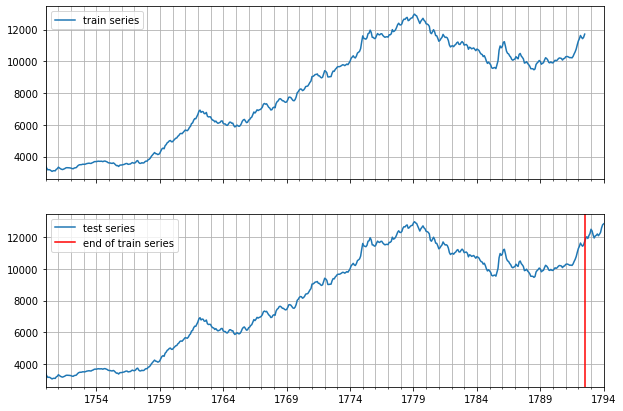

In [6]:
train_entry_a = next(iter(dataset_a.train))
test_entry_a = next(iter(dataset_a.test))

print(train_entry_a.keys())
print(test_entry_a.keys())
print("length train:", len(dataset_a.train))
print("length test:", len(dataset_a.test))


print("\nstart:\n",train_entry_a["start"])
print("target:\n", train_entry_a["target"][:10])
print("feat_static_cat:\n", train_entry_a["feat_static_cat"])

train_series_a = to_pandas(train_entry_a)
test_series_a = to_pandas(test_entry_a)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series_a.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series_a.plot(ax=ax[1])
ax[1].axvline(train_series_a.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

## Dataset $B_{42}$

dict_keys(['start', 'item_id', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'item_id', 'target', 'feat_static_cat', 'source'])
length train: 10975
length test: 10975

start:
 1750-01-31 00:00:00
target:
 [2471.26 2341.11 2515.59 2442.99 1995.44 2508.72 2591.77 2403.93 2532.24
 2341.79]
feat_static_cat:
 [1]


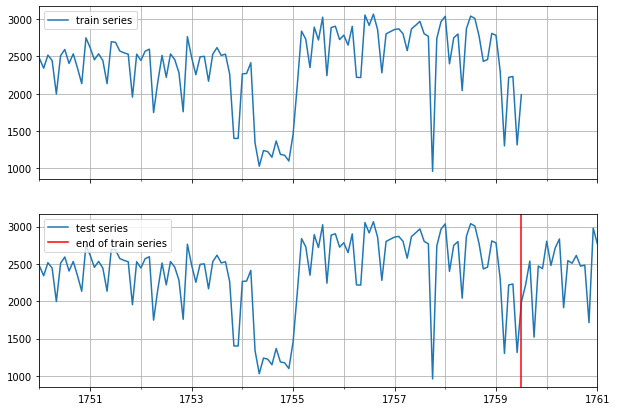

In [7]:
train_entry_b = next(iter(dataset_b.train))
test_entry_b = next(iter(dataset_b.test))

print(train_entry_b.keys())
print(test_entry_b.keys())
print("length train:", len(dataset_b.train))
print("length test:", len(dataset_b.test))

print("\nstart:\n",train_entry_b["start"])
print("target:\n", train_entry_b["target"][:10])
print("feat_static_cat:\n", train_entry_b["feat_static_cat"])

train_series_b = to_pandas(train_entry_b)
test_series_b = to_pandas(test_entry_b)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series_b.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series_b.plot(ax=ax[1])
ax[1].axvline(train_series_b.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

## Comparison of both datasets

- Compare whether both datasets have the same length


In [8]:
# Check length
print("Length test train:", len(dataset_a.train) == len(dataset_b.train))
print("Length test test:", len(dataset_a.test) == len(dataset_b.test))

# Check frequency
print("Frequency test:",(dataset_a.metadata.freq == dataset_b.metadata.freq))


Length test train: True
Length test test: True
Frequency test: True


## Modeling: DeepAR

In [9]:
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

from gluonts.model.deepar import DeepAREstimator

In [10]:
# A: dataset_a
# B: dataset_b
print(dataset_a)
print("\n", dataset_b)

TrainDatasets(metadata=<MetaData freq='M' target=None feat_static_cat=[<CategoricalFeatureInfo name='feat_static_cat' cardinality='10975'>] feat_static_real=[] feat_dynamic_real=[] feat_dynamic_cat=[] prediction_length=18>, train=<gluonts.dataset.common.FileDataset object at 0x00000169C9017E48>, test=<gluonts.dataset.common.FileDataset object at 0x00000169D9209C50>)

 TrainDatasets(metadata=<MetaData freq='M' target=None feat_static_cat=[<CategoricalFeatureInfo name='feat_static_cat' cardinality='10975'>] feat_static_real=[] feat_dynamic_real=[] feat_dynamic_cat=[] prediction_length=18>, train=<gluonts.dataset.common.FileDataset object at 0x00000169DADC6AC8>, test=<gluonts.dataset.common.FileDataset object at 0x00000169DADC6F60>)


In [11]:
def deepar_train_eval(dataname_a, dataname_b, seed=42, epochs=100, num_batches=100):
    """
    Function that trains a network using data from dataset B and evaluates the trained network on dataset A.
    Dataset A is the dataset of interest for our analysis. 
    """    
    
    dataset_a = get_dataset(dataname_a, regenerate=False)
    dataset_b = get_dataset(dataname_b, regenerate=False)
    
    # Assert checks
    assert (dataset_a.metadata.freq == dataset_b.metadata.freq)
    assert ( len(dataset_a.train)==len(dataset_b.train) )
    assert ( len(dataset_a.test)==len(dataset_b.test))
    
    mx.random.seed(seed)
    np.random.seed(seed)

    # define trainer
    trainer=Trainer(
        ctx=mx.cpu(),
        epochs=epochs,
        num_batches_per_epoch=num_batches,
        learning_rate=1e-3,
    )

    estimator=DeepAREstimator(
        trainer=trainer,
        context_length=dataset_a.metadata.prediction_length,
        prediction_length=dataset_a.metadata.prediction_length,
        freq=dataset_a.metadata.freq,
        use_feat_static_cat=False,
    )

    # predictor trained on dataset_b
    predictor=estimator.train(training_data=dataset_b.train)
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset_a.test, predictor=predictor, num_samples=100
    )
    
    agg_metrics, item_metrics = Evaluator()(
        ts_it, forecast_it, num_series = len(dataset_a.test))
    
    metrics=["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
    output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}
    
    output["seed"]=seed
    output["epochs"]=epochs
    output["num_batches"]=num_batches
    output["train data"]=dataname_b
    output["eval data"]=dataname_a
    

    df=pd.DataFrame([output])

    return df

    

## Subsets

In [12]:
dataname_a = "m4_monthly_micro"

dataname_b42 = "m4_monthly_subset10975_seed42"
dataname_b43 = "m4_monthly_subset10975_seed43"
dataname_b44 = "m4_monthly_subset10975_seed44"
dataname_b45 = "m4_monthly_subset10975_seed45"
dataname_b46 = "m4_monthly_subset10975_seed46"

dataname_b47 = "m4_monthly_subset10975_seed47"
dataname_b48 = "m4_monthly_subset10975_seed48"
dataname_b49 = "m4_monthly_subset10975_seed49"
dataname_b50 = "m4_monthly_subset10975_seed50"
dataname_b51 = "m4_monthly_subset10975_seed51"

## Study 1: Random sample training vs. domain-specific training

### Run I.: Training: A, Eval: A

- 10 trials on same dataset from the same domain!
- Seeds from 42 to 51

In [13]:
results = pd.DataFrame()
# Compare ten trials 

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a=dataname_a, dataname_b=dataname_a, seed=i, epochs=100, num_batches=50)
    pprint(df)
    results = results.append(df)
    
results

Next seed: 42


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_micro.
INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_micro.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 10.25it/s, avg_epoch_loss=7.37]
INFO:root:Epoch[0] Elapsed time 4.881 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.373995
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 14.56it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[1] Elapsed time 3.458 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.303696
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.12it/s, avg_epoch_loss=7.93]
INFO:root:Epoch[2] Elapsed time 3.312 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.925689
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.93it/s, avg_epoch_loss=7.64]
I

INFO:root:Epoch[36] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 16.34it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[36] Elapsed time 3.076 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.951765
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 14.27it/s, avg_epoch_loss=7.14]
INFO:root:Epoch[37] Elapsed time 3.507 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.141712
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:02<00:00, 16.67it/s, avg_epoch_loss=6.06]
INFO:root:Epoch[38] Elapsed time 3.003 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.062774
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 16.53it/s, avg_epoch_loss=5.57]
INFO:root:Epoch[39] Elapsed time 3.025 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.566544
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 16.62it/s, avg_epoch_loss=6.17]
INFO:root:Ep

INFO:root:Epoch[73] Learning rate is 0.0005
100%|██████████| 50/50 [00:03<00:00, 15.39it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[73] Elapsed time 3.269 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.365507
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 50/50 [00:05<00:00,  9.98it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[74] Elapsed time 5.021 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.860808
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 50/50 [00:08<00:00,  5.91it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[75] Elapsed time 8.461 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.346498
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:03<00:00, 15.19it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[76] Elapsed time 3.294 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.970043
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:03<00:00, 13.08it/s, avg_epoch_loss=7.27]
INFO:ro

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  0.929188  0.149033  21.958328            0.138405            0.104664   

   seed  epochs  num_batches        train data         eval data  
0    42     100           50  m4_monthly_micro  m4_monthly_micro  
Next seed: 43


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_micro.
INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_micro.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 14.41it/s, avg_epoch_loss=7.11]
INFO:root:Epoch[0] Elapsed time 3.500 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.107024
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.84it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[1] Elapsed time 3.172 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.322156
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.39it/s, avg_epoch_loss=7.77]
INFO:root:Epoch[2] Elapsed time 3.250 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.771999
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.61it/s, avg_epoch_loss=7.6]
I

INFO:root:Epoch[35] Evaluation metric 'epoch_loss'=7.116668
INFO:root:Epoch[36] Learning rate is 0.0005
100%|██████████| 50/50 [00:03<00:00, 15.69it/s, avg_epoch_loss=7.09]
INFO:root:Epoch[36] Elapsed time 3.187 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=7.086772
INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 50/50 [00:03<00:00, 14.29it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[37] Elapsed time 3.500 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.268521
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 50/50 [00:03<00:00, 16.41it/s, avg_epoch_loss=5.93]
INFO:root:Epoch[38] Elapsed time 3.062 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.928809
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 50/50 [00:03<00:00, 16.41it/s, avg_epoch_loss=5.53]
INFO:root:Epoch[39] Elapsed time 3.047 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.525501
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████|

100%|██████████| 50/50 [00:03<00:00, 16.24it/s, avg_epoch_loss=5.51]
INFO:root:Epoch[72] Elapsed time 3.078 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.507911
INFO:root:Epoch[73] Learning rate is 0.000125
100%|██████████| 50/50 [00:03<00:00, 16.16it/s, avg_epoch_loss=5.29]
INFO:root:Epoch[73] Elapsed time 3.094 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.285567
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 50/50 [00:03<00:00, 15.84it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[74] Elapsed time 3.156 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.480709
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 50/50 [00:03<00:00, 15.69it/s, avg_epoch_loss=7.52]
INFO:root:Epoch[75] Elapsed time 3.187 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.520578
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 50/50 [00:03<00:00, 16.50it/s, avg_epoch_loss=7.16]
INFO:root:Epoch[76] Elapsed time 3.031 seco

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  0.934753  0.149888  22.408586            0.138921            0.102765   

   seed  epochs  num_batches        train data         eval data  
0    43     100           50  m4_monthly_micro  m4_monthly_micro  
Next seed: 44


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_micro.
INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_micro.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.23it/s, avg_epoch_loss=7.65]
INFO:root:Epoch[0] Elapsed time 4.453 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.653389
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 14.48it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[1] Elapsed time 3.453 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.395517
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.61it/s, avg_epoch_loss=7.8]
INFO:root:Epoch[2] Elapsed time 3.219 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.798629
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.69it/s, avg_epoch_loss=7.47]
IN

INFO:root:Epoch[35] Evaluation metric 'epoch_loss'=7.196572
INFO:root:Epoch[36] Learning rate is 0.0005
100%|██████████| 50/50 [00:04<00:00, 11.55it/s, avg_epoch_loss=7.17]
INFO:root:Epoch[36] Elapsed time 4.328 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=7.166303
INFO:root:Loading parameters from best epoch (26)
INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 50/50 [00:04<00:00, 11.27it/s, avg_epoch_loss=7.75]
INFO:root:Epoch[37] Elapsed time 4.453 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.746553
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:03<00:00, 15.24it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[38] Elapsed time 3.281 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.106207
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:03<00:00, 16.50it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[39] Elapsed time 3.047 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.734485
INFO:ro

100%|██████████| 50/50 [00:03<00:00, 16.41it/s, avg_epoch_loss=5.91]
INFO:root:Epoch[72] Elapsed time 3.062 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.908636
INFO:root:Epoch[73] Learning rate is 0.000125
100%|██████████| 50/50 [00:03<00:00, 16.33it/s, avg_epoch_loss=5.55]
INFO:root:Epoch[73] Elapsed time 3.078 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.551184
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 50/50 [00:03<00:00, 16.24it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[74] Elapsed time 3.078 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.012096
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 50/50 [00:03<00:00, 16.16it/s, avg_epoch_loss=7.61]
INFO:root:Epoch[75] Elapsed time 3.094 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.609990
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 50/50 [00:03<00:00, 16.41it/s, avg_epoch_loss=7.12]
INFO:root:Epoch[76] Elapsed time 3.047 seco

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  0.993306  0.154146  24.63681            0.143966            0.110891    44   

   epochs  num_batches        train data         eval data  
0     100           50  m4_monthly_micro  m4_monthly_micro  
Next seed: 45


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_micro.
INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_micro.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 14.41it/s, avg_epoch_loss=7.4]
INFO:root:Epoch[0] Elapsed time 3.469 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.403637
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.53it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[1] Elapsed time 3.234 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.489950
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.53it/s, avg_epoch_loss=7.87]
INFO:root:Epoch[2] Elapsed time 3.234 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.865835
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 15.53it/s, avg_epoch_loss=7.54]
I

INFO:root:Epoch[35] Elapsed time 3.094 seconds
INFO:root:Epoch[35] Evaluation metric 'epoch_loss'=7.192506
INFO:root:Epoch[36] Learning rate is 0.0005
100%|██████████| 50/50 [00:03<00:00, 14.88it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[36] Elapsed time 3.375 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=7.273091
INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 50/50 [00:03<00:00, 14.68it/s, avg_epoch_loss=7.2]
INFO:root:Epoch[37] Elapsed time 3.406 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.201812
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 50/50 [00:03<00:00, 16.00it/s, avg_epoch_loss=5.98]
INFO:root:Epoch[38] Elapsed time 3.125 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.981788
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 50/50 [00:03<00:00, 16.14it/s, avg_epoch_loss=5.65]
INFO:root:Epoch[39] Elapsed time 3.114 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.648166
INFO:root:Epoc

INFO:root:Epoch[72] Elapsed time 3.125 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.644751
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 50/50 [00:03<00:00, 16.00it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[73] Elapsed time 3.125 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.381816
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 50/50 [00:03<00:00, 15.19it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[74] Elapsed time 3.307 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.326401
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 50/50 [00:03<00:00, 15.61it/s, avg_epoch_loss=7.52]
INFO:root:Epoch[75] Elapsed time 3.203 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.518917
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 50/50 [00:03<00:00, 14.95it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[76] Elapsed time 3.344 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.911715
INFO:root

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.191049  0.155502  25.922684            0.144423            0.112021   

   seed  epochs  num_batches        train data         eval data  
0    45     100           50  m4_monthly_micro  m4_monthly_micro  
Next seed: 46


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_micro.
INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_micro.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 10.92it/s, avg_epoch_loss=7.43]
INFO:root:Epoch[0] Elapsed time 4.594 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.426674
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 13.12it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[1] Elapsed time 3.828 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.367545
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 14.35it/s, avg_epoch_loss=7.84]
INFO:root:Epoch[2] Elapsed time 3.484 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.837233
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 14.75it/s, avg_epoch_loss=7.56]


INFO:root:Epoch[35] Evaluation metric 'epoch_loss'=7.087503
INFO:root:Epoch[36] Learning rate is 0.0005
100%|██████████| 50/50 [00:03<00:00, 14.82it/s, avg_epoch_loss=7.36]
INFO:root:Epoch[36] Elapsed time 3.375 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=7.362945
INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 50/50 [00:03<00:00, 14.49it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[37] Elapsed time 3.452 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.948737
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 50/50 [00:03<00:00, 15.92it/s, avg_epoch_loss=5.85]
INFO:root:Epoch[38] Elapsed time 3.156 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.854134
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 50/50 [00:03<00:00, 16.24it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[39] Elapsed time 3.078 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.904592
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 

INFO:root:Epoch[72] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:03<00:00, 15.46it/s, avg_epoch_loss=5.83]
INFO:root:Epoch[72] Elapsed time 3.250 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.833168
INFO:root:Epoch[73] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:03<00:00, 15.09it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[73] Elapsed time 3.312 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.693649
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:03<00:00, 15.09it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[74] Elapsed time 3.328 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.584281
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:03<00:00, 14.61it/s, avg_epoch_loss=7.45]
INFO:root:Epoch[75] Elapsed time 3.422 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.445648
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:05<00:00,  9.86it/s, avg_epoch_loss=7.2

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  0.978806  0.153753  22.554995            0.143943            0.105006   

   seed  epochs  num_batches        train data         eval data  
0    46     100           50  m4_monthly_micro  m4_monthly_micro  
Next seed: 47


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_micro.
INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_micro.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.02it/s, avg_epoch_loss=7.77]
INFO:root:Epoch[0] Elapsed time 4.159 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.766749
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.56it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[1] Elapsed time 4.328 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.324820
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 14.48it/s, avg_epoch_loss=7.71]
INFO:root:Epoch[2] Elapsed time 3.457 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.711579
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 14.95it/s, avg_epoch_loss=7.54]


INFO:root:Epoch[35] Elapsed time 3.484 seconds
INFO:root:Epoch[35] Evaluation metric 'epoch_loss'=7.147471
INFO:root:Epoch[36] Learning rate is 0.0005
100%|██████████| 50/50 [00:05<00:00,  9.12it/s, avg_epoch_loss=7.17]
INFO:root:Epoch[36] Elapsed time 5.498 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=7.172998
INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 50/50 [00:03<00:00, 13.22it/s, avg_epoch_loss=7.32]
INFO:root:Epoch[37] Elapsed time 3.781 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.319350
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 50/50 [00:03<00:00, 15.46it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[38] Elapsed time 3.234 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.013045
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 50/50 [00:03<00:00, 16.08it/s, avg_epoch_loss=5.68]
INFO:root:Epoch[39] Elapsed time 3.109 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.680129
INFO:root:Epo

INFO:root:Epoch[71] Evaluation metric 'epoch_loss'=7.016598
INFO:root:Epoch[72] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:09<00:00,  5.40it/s, avg_epoch_loss=6]
INFO:root:Epoch[72] Elapsed time 9.274 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.999269
INFO:root:Epoch[73] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:06<00:00,  7.39it/s, avg_epoch_loss=5.78]
INFO:root:Epoch[73] Elapsed time 6.779 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.784267
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:05<00:00,  9.08it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[74] Elapsed time 5.512 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.551850
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:03<00:00, 15.83it/s, avg_epoch_loss=7.71]
INFO:root:Epoch[75] Elapsed time 3.165 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.708477
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|████

       MASE    sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.050641  0.15655  26.80401            0.145567            0.117409    47   

   epochs  num_batches        train data         eval data  
0     100           50  m4_monthly_micro  m4_monthly_micro  
Next seed: 48


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_micro.
INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_micro.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 10.60it/s, avg_epoch_loss=7.41]
INFO:root:Epoch[0] Elapsed time 4.734 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.406677
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.94it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[1] Elapsed time 4.187 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.379831
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.90it/s, avg_epoch_loss=7.91]
INFO:root:Epoch[2] Elapsed time 4.219 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.914289
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.99it/s, avg_epoch_loss=7.65]


INFO:root:Epoch[35] Elapsed time 4.016 seconds
INFO:root:Epoch[35] Evaluation metric 'epoch_loss'=7.308690
INFO:root:Epoch[36] Learning rate is 0.0005
100%|██████████| 50/50 [00:04<00:00, 11.15it/s, avg_epoch_loss=7.32]
INFO:root:Epoch[36] Elapsed time 4.500 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=7.315276
INFO:root:Loading parameters from best epoch (26)
INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 50/50 [00:04<00:00, 10.85it/s, avg_epoch_loss=8.12]
INFO:root:Epoch[37] Elapsed time 4.609 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=8.116954
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:04<00:00, 12.40it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[38] Elapsed time 4.031 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.448599
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:03<00:00, 12.60it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[39] Elapsed time 3.969 seconds
INFO:root:Epoch[39] E

INFO:root:Epoch[72] Learning rate is 0.000125
100%|██████████| 50/50 [00:04<00:00, 12.26it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[72] Elapsed time 4.078 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=6.325953
INFO:root:Epoch[73] Learning rate is 0.000125
100%|██████████| 50/50 [00:04<00:00, 11.81it/s, avg_epoch_loss=5.89]
INFO:root:Epoch[73] Elapsed time 4.250 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.893809
INFO:root:Loading parameters from best epoch (53)
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:04<00:00, 11.85it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[74] Elapsed time 4.219 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.528870
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:04<00:00, 12.26it/s, avg_epoch_loss=8.04]
INFO:root:Epoch[75] Elapsed time 4.094 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=8.040859
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████|

       MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.013597  0.15995  24.885659            0.148567            0.108496    48   

   epochs  num_batches        train data         eval data  
0     100           50  m4_monthly_micro  m4_monthly_micro  
Next seed: 49


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_micro.
INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_micro.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 10.92it/s, avg_epoch_loss=7.67]
INFO:root:Epoch[0] Elapsed time 4.578 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.668884
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.88it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[1] Elapsed time 5.062 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.509947
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.51it/s, avg_epoch_loss=8]
INFO:root:Epoch[2] Elapsed time 4.344 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=8.001795
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.11it/s, avg_epoch_loss=7.77]
INF

INFO:root:Epoch[36] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.55it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[36] Elapsed time 4.344 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=7.272089
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.27it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[37] Elapsed time 4.437 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.862356
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.17it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[38] Elapsed time 4.125 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.792118
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.03it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[39] Elapsed time 4.156 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.718348
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.81it/s, avg_epoch_loss=6.74]
INFO:root:Ep

INFO:root:Epoch[73] Learning rate is 0.0005
100%|██████████| 50/50 [00:04<00:00, 11.94it/s, avg_epoch_loss=5.34]
INFO:root:Epoch[73] Elapsed time 4.187 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.340811
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 50/50 [00:04<00:00, 11.94it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[74] Elapsed time 4.187 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.225891
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 50/50 [00:04<00:00, 11.81it/s, avg_epoch_loss=7.24]
INFO:root:Epoch[75] Elapsed time 4.234 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.237971
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:04<00:00, 12.08it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[76] Elapsed time 4.156 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.890921
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:05<00:00,  9.55it/s, avg_epoch_loss=7.32]
INFO:ro

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.457071  0.158023  32.427212            0.148115            0.136691   

   seed  epochs  num_batches        train data         eval data  
0    49     100           50  m4_monthly_micro  m4_monthly_micro  
Next seed: 50


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_micro.
INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_micro.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 10.67it/s, avg_epoch_loss=7.09]
INFO:root:Epoch[0] Elapsed time 4.687 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.094286
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.64it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[1] Elapsed time 4.297 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.395573
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.51it/s, avg_epoch_loss=7.81]
INFO:root:Epoch[2] Elapsed time 4.359 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.811285
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.36it/s, avg_epoch_loss=7.62]
I

100%|██████████| 50/50 [00:04<00:00, 12.21it/s, avg_epoch_loss=7.37]
INFO:root:Epoch[35] Elapsed time 4.094 seconds
INFO:root:Epoch[35] Evaluation metric 'epoch_loss'=7.374172
INFO:root:Epoch[36] Learning rate is 0.00025
100%|██████████| 50/50 [00:04<00:00, 11.72it/s, avg_epoch_loss=7.45]
INFO:root:Epoch[36] Elapsed time 4.265 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=7.450613
INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 50/50 [00:04<00:00, 11.27it/s, avg_epoch_loss=7.56]
INFO:root:Epoch[37] Elapsed time 4.437 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.562612
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:04<00:00, 12.36it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[38] Elapsed time 4.047 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.482877
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:04<00:00, 12.37it/s, avg_epoch_loss=5.98]
INFO:root:Epoch[39] Elapsed time 4.057 seconds


INFO:root:Epoch[71] Elapsed time 4.359 seconds
INFO:root:Epoch[71] Evaluation metric 'epoch_loss'=7.387284
INFO:root:Epoch[72] Learning rate is 5e-05
100%|██████████| 50/50 [00:04<00:00, 11.72it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[72] Elapsed time 4.281 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=6.207548
INFO:root:Epoch[73] Learning rate is 5e-05
100%|██████████| 50/50 [00:03<00:00, 12.70it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[73] Elapsed time 3.937 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.101450
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 50/50 [00:04<00:00, 12.45it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[74] Elapsed time 4.031 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.778878
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 50/50 [00:04<00:00, 12.36it/s, avg_epoch_loss=7.82]
INFO:root:Epoch[75] Elapsed time 4.062 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.815114
INFO:root:Epoch[76

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.134093  0.167956  28.122113            0.155697            0.117248   

   seed  epochs  num_batches        train data         eval data  
0    50     100           50  m4_monthly_micro  m4_monthly_micro  
Next seed: 51


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_micro.
INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_micro.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.34it/s, avg_epoch_loss=7.2]
INFO:root:Epoch[0] Elapsed time 5.374 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.197145
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 10.85it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[1] Elapsed time 4.615 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.295375
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:06<00:00,  7.63it/s, avg_epoch_loss=7.79]
INFO:root:Epoch[2] Elapsed time 6.560 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.786872
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:07<00:00,  6.79it/s, avg_epoch_loss=7.52]
IN

INFO:root:Epoch[35] Elapsed time 4.026 seconds
INFO:root:Epoch[35] Evaluation metric 'epoch_loss'=7.203466
INFO:root:Epoch[36] Learning rate is 0.0005
100%|██████████| 50/50 [00:04<00:00, 10.85it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[36] Elapsed time 4.609 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=7.079242
INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 50/50 [00:04<00:00, 10.29it/s, avg_epoch_loss=7.43]
INFO:root:Epoch[37] Elapsed time 4.861 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.433210
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 50/50 [00:04<00:00, 10.82it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[38] Elapsed time 4.619 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.314089
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 50/50 [00:03<00:00, 12.58it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[39] Elapsed time 3.973 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.005941
INFO:root:Epo

INFO:root:Epoch[72] Learning rate is 0.000125
100%|██████████| 50/50 [00:04<00:00, 10.49it/s, avg_epoch_loss=6]
INFO:root:Epoch[72] Elapsed time 4.772 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.995420
INFO:root:Epoch[73] Learning rate is 0.000125
100%|██████████| 50/50 [00:04<00:00, 11.53it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[73] Elapsed time 4.344 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.754777
INFO:root:Loading parameters from best epoch (53)
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:04<00:00, 12.02it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[74] Elapsed time 4.167 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.755308
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:04<00:00, 11.91it/s, avg_epoch_loss=7.94]
INFO:root:Epoch[75] Elapsed time 4.201 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.935427
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 50

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.054615  0.156077  24.043065            0.144867            0.110109   

   seed  epochs  num_batches        train data         eval data  
0    51     100           50  m4_monthly_micro  m4_monthly_micro  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches,train data,eval data
0,0.929188,0.149033,21.958328,0.138405,0.104664,42,100,50,m4_monthly_micro,m4_monthly_micro
0,0.934753,0.149888,22.408586,0.138921,0.102765,43,100,50,m4_monthly_micro,m4_monthly_micro
0,0.993306,0.154146,24.636810,0.143966,0.110891,44,100,50,m4_monthly_micro,m4_monthly_micro
0,1.191049,0.155502,25.922684,0.144423,0.112021,45,100,50,m4_monthly_micro,m4_monthly_micro
0,0.978806,0.153753,22.554995,0.143943,0.105006,46,100,50,m4_monthly_micro,m4_monthly_micro
0,1.050641,0.156550,26.804010,0.145567,0.117409,47,100,50,m4_monthly_micro,m4_monthly_micro
0,1.013597,0.159950,24.885659,0.148567,0.108496,48,100,50,m4_monthly_micro,m4_monthly_micro
0,1.457071,0.158023,32.427212,0.148115,0.136691,49,100,50,m4_monthly_micro,m4_monthly_micro
0,1.134093,0.167956,28.122113,0.155697,0.117248,50,100,50,m4_monthly_micro,m4_monthly_micro
0,1.054615,0.156077,24.043065,0.144867,0.110109,51,100,50,m4_monthly_micro,m4_monthly_micro


### Run II.: Training: A, Eval: B

- 10 trials on 10 randomly selected datasets from frequency `monthly`
- seeds from 42 to 52

In [14]:
# b42
df=deepar_train_eval(dataname_a=dataname_a, dataname_b=dataname_b42, seed=42, epochs=100, num_batches=50)
df

INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_micro.
INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_subset10975_seed42.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:06<00:00,  8.09it/s, avg_epoch_loss=7.89]
INFO:root:Epoch[0] Elapsed time 6.197 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.894341
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.84it/s, avg_epoch_loss=7.36]
INFO:root:Epoch[1] Elapsed time 5.084 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.360983
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.83it/s, avg_epoch_loss=7.28]
INFO:root:Epoch[2] Elapsed time 5.097 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.282300
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.99it/s, avg_epoc

INFO:root:Epoch[35] Evaluation metric 'epoch_loss'=6.589039
INFO:root:Epoch[36] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  8.43it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[36] Elapsed time 5.939 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.648017
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.88it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[37] Elapsed time 5.069 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.630247
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.96it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[38] Elapsed time 5.027 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.572501
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.86it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[39] Elapsed time 5.082 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.630696
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/5

INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=6.449579
INFO:root:Epoch[73] Learning rate is 0.0005
100%|██████████| 50/50 [00:05<00:00,  9.90it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[73] Elapsed time 5.053 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.430140
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 50/50 [00:05<00:00,  9.82it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[74] Elapsed time 5.096 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.413039
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 50/50 [00:05<00:00,  9.86it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[75] Elapsed time 5.080 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.306320
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:04<00:00, 10.18it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[76] Elapsed time 4.920 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.425409
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████|

,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches,train data,eval data
0,1.282679,0.15529,13.40793,0.145691,0.093094,42,100,50,m4_monthly_subset10975_seed42,m4_monthly_micro


In [15]:
# b43
df=deepar_train_eval(dataname_a=dataname_a, dataname_b=dataname_b43, seed=43, epochs=100, num_batches=50)
df

INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_micro.
INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_subset10975_seed43.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.69it/s, avg_epoch_loss=7.77]
INFO:root:Epoch[0] Elapsed time 5.173 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.771486
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.20it/s, avg_epoch_loss=7.41]
INFO:root:Epoch[1] Elapsed time 4.473 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.413767
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.72it/s, avg_epoch_loss=7.24]
INFO:root:Epoch[2] Elapsed time 4.270 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.243224
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.87it/s, avg_epoc

INFO:root:Epoch[35] Elapsed time 6.581 seconds
INFO:root:Epoch[35] Evaluation metric 'epoch_loss'=6.612162
INFO:root:Epoch[36] Learning rate is 0.0005
100%|██████████| 50/50 [00:06<00:00,  7.32it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[36] Elapsed time 6.853 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.680654
INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 50/50 [00:06<00:00,  7.87it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[37] Elapsed time 6.369 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.531563
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 50/50 [00:05<00:00,  8.40it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[38] Elapsed time 5.959 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.573899
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 50/50 [00:05<00:00,  8.51it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[39] Elapsed time 5.881 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.605522
INFO:root:Epo

INFO:root:Epoch[72] Learning rate is 0.000125
100%|██████████| 50/50 [00:04<00:00, 11.06it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[72] Elapsed time 4.523 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=6.531196
INFO:root:Epoch[73] Learning rate is 0.000125
100%|██████████| 50/50 [00:04<00:00, 11.20it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[73] Elapsed time 4.480 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.586189
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 50/50 [00:04<00:00, 11.31it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[74] Elapsed time 4.429 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.538783
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 50/50 [00:04<00:00, 10.74it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[75] Elapsed time 4.662 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.663233
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 50/50 [00:04<00:00, 10.18it/s, avg_epoch_loss=6.6

,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches,train data,eval data
0,0.920648,0.149745,10.832516,0.136068,0.090791,43,100,50,m4_monthly_subset10975_seed43,m4_monthly_micro


In [ ]:
# b44
df=deepar_train_eval(dataname_a=dataname_a, dataname_b=dataname_b44, seed=44, epochs=100, num_batches=50)
df

INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_micro.
INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_subset10975_seed44.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:11<00:00,  4.22it/s, avg_epoch_loss=8.03]
INFO:root:Epoch[0] Elapsed time 11.892 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.029555
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  8.43it/s, avg_epoch_loss=7.47]
INFO:root:Epoch[1] Elapsed time 5.937 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.470675
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  8.79it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[2] Elapsed time 5.701 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.256172
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:06<00:00,  8.00it/s, avg_epo

INFO:root:Epoch[35] Evaluation metric 'epoch_loss'=6.577393
INFO:root:Epoch[36] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.42it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[36] Elapsed time 5.327 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.626101
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.29it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[37] Elapsed time 5.389 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.538059
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.21it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[38] Elapsed time 5.433 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.462476
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:06<00:00,  7.41it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[39] Elapsed time 6.762 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.557015
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/5

INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=6.299455
INFO:root:Epoch[73] Learning rate is 0.0005
100%|██████████| 50/50 [00:06<00:00,  8.21it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[73] Elapsed time 6.098 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.418778
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 50/50 [00:06<00:00,  7.23it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[74] Elapsed time 6.926 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.376445
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 50/50 [00:06<00:00,  7.79it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[75] Elapsed time 6.426 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.292695
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:06<00:00,  7.31it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[76] Elapsed time 6.847 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.357675
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████|

In [ ]:
# b45
df=deepar_train_eval(dataname_a=dataname_a, dataname_b=dataname_b45, seed=45, epochs=100, num_batches=50)
df

In [ ]:
# b46
df=deepar_train_eval(dataname_a=dataname_a, dataname_b=dataname_b46, seed=46, epochs=100, num_batches=50)
df

In [ ]:
# b47
df=deepar_train_eval(dataname_a=dataname_a, dataname_b=dataname_b47, seed=47, epochs=100, num_batches=50)
df

In [ ]:
# b48
df=deepar_train_eval(dataname_a=dataname_a, dataname_b=dataname_b48, seed=48, epochs=100, num_batches=50)
df

In [ ]:
# b49
df=deepar_train_eval(dataname_a=dataname_a, dataname_b=dataname_b49, seed=49, epochs=100, num_batches=50)
df

In [ ]:
# b50
df=deepar_train_eval(dataname_a=dataname_a, dataname_b=dataname_b46, seed=50, epochs=100, num_batches=50)
df

In [ ]:
# b51
df=deepar_train_eval(dataname_a=dataname_a, dataname_b=dataname_b51, seed=51, epochs=100, num_batches=50)
df